In [60]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

In [2]:
data_folder = "data"

image_files = [f for f in os.listdir(data_folder) if f.endswith("png")]

### Chose a random image to train a neural representation on

Image dimensions: 1848x2040, 3 channels


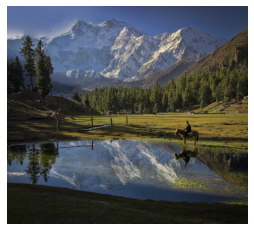

In [50]:
# Set random seed to 1
random.seed(1)

random_img_file = random.choice(image_files)
img_path = os.path.join(data_folder, random_img_file)

# load the image
img_original = Image.open(img_path)
# convert image to numpy array
img_np_original = np.array(img_original)
# display the image
plt.imshow(img_np_original)
plt.axis("off")

# Original resolution of the image

height, width, channels = img_np_original.shape
print(f"Image dimensions: {height}x{width}, {channels} channels") # r,g,b channels

Downsize factor: 3
Resized image dimensions: 616x680, 3 channels


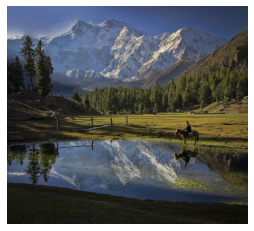

In [49]:
# Now we will downsize the original image to a smaller resolution using a random integer factor
random.seed(1)
downsize_factor = random.randint(1, 10)
print(f"Downsize factor: {downsize_factor}")
img_resized = img_original.resize((width // downsize_factor, height // downsize_factor))

# convert image to numpy array
img_np_resized = np.array(img_resized)

# display the resized image
plt.imshow(img_np_resized)
plt.axis("off")

# Print the resolution of the new image
height_resized, width_resized, channels = img_np_resized.shape
print(f"Resized image dimensions: {height_resized}x{width_resized}, {channels} channels")

### We will next normalize the pixels to have values between 0 and 1

In [42]:
# Print the max and min values of the downsampled image
print(f"Max value in downsampled image: {np.max(img_np_resized)}")
print(f"Min value in downsampled image: {np.min(img_np_resized)}")

Max value in downsampled image: 255
Min value in downsampled image: 0


In [43]:
img_np_resized = img_np_resized / 255.0 # Normalize the rgb values

# Now the max and min values should be between 0 and 1
print(f"Max value in downsampled image: {np.max(img_np_resized)}")
print(f"Min value in downsampled image: {np.min(img_np_resized)}")

Max value in downsampled image: 1.0
Min value in downsampled image: 0.0


### Normalize the coordinates of the image to be between 0 and 1.

In [73]:
def get_normalized_coordinates(h, w):
    """
    Returns normalized coordinates of the image
    """
    x = np.linspace(0, 1, w)
    y = np.linspace(0, 1, h)
    x, y = np.meshgrid(x, y)
    coordinates = np.stack((x, y), axis=2) # shape (h, w, 2)
    coordinates = coordinates.reshape(-1, 2) # shape (h*w, 2)
    return coordinates

In [74]:
normalized_coordinates = get_normalized_coordinates(height_resized, width_resized)
pixel_values = img_np_resized.reshape(-1, channels)

In [56]:
# Check shapes
print(f"Normalized coordinates shape: {normalized_coordinates.shape}")
print(f"Pixel values shape: {pixel_values.shape}")

Normalized coordinates shape: (418880, 2)
Pixel values shape: (418880, 3)


In [67]:
# Define a custom dataset class
class ImageDataset(Dataset):
    def __init__(self, coordinates, pixel_values):
        self.coordinates = coordinates.astype(np.float32)
        self.pixel_values = pixel_values.astype(np.float32)
    
    def __len__(self):
        return len(self.coordinates)
    
    def __getitem__(self, idx):
        coord = self.coordinates[idx]
        pixel = self.pixel_values[idx]
        return coord, pixel
    

# Create dataset and dataloader
dataset = ImageDataset(normalized_coordinates, pixel_values)
dataloader = DataLoader(dataset, batch_size=2048, shuffle=True)

  2%|▏         | 1/50 [00:05<04:34,  5.61s/it]

Epoch 0, Loss: 7199.651825


 22%|██▏       | 11/50 [00:55<03:18,  5.08s/it]

Epoch 10, Loss: 7182.783136


 42%|████▏     | 21/50 [01:47<02:39,  5.51s/it]

Epoch 20, Loss: 7183.104526


 62%|██████▏   | 31/50 [02:44<01:48,  5.69s/it]

Epoch 30, Loss: 7183.774390


 82%|████████▏ | 41/50 [03:34<00:45,  5.08s/it]

Epoch 40, Loss: 7183.293993


100%|██████████| 50/50 [04:31<00:00,  5.44s/it]


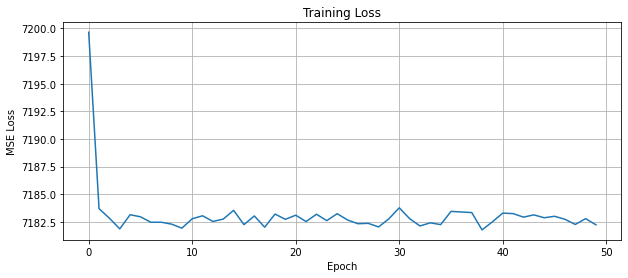

In [71]:
# Define a simple MLP for the INR
class INRModel(nn.Module):
    def __init__(self, input_dim=2, output_dim=3, hidden_dim=256, num_layers=2):
        super().__init__()
        
        layers = []
        # First layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        
        # Hidden layers
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        
        # Output layer
        layers.append(nn.Linear(hidden_dim, output_dim))
        layers.append(nn.Sigmoid())  # Ensure output is in [0, 1] range since the rgb values are normalized
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Create and train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = INRModel(input_dim=2, output_dim=channels, hidden_dim=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3) # Base parameters
criterion = nn.MSELoss()

# Training loop
num_epochs = 50
losses = []

for epoch in tqdm(range(num_epochs)):
    # Create random batches
    total_loss = 0
    
    for batch_coords, batch_pixels in dataloader:
        batch_coords = batch_coords.to(device)
        batch_pixels = batch_pixels.to(device)
        
        # Forward pass
        pred_pixels = model(batch_coords)
        
        # Compute loss
        loss = criterion(pred_pixels, batch_pixels)
        total_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

# Plot the loss curve
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

In [ ]:
# Generate normalized coordinates for the original image size
original_coords = get_normalized_coordinates(height, width)

# Convert to PyTorch tensor
original_coords_tensor = torch.from_numpy(original_coords).float().to(device)

# Use the trained model to predict the RGB values for these coordinates
with torch.no_grad():
    pred_pixels = []
    batch_size = 2048
    for i in range(0, original_coords_tensor.shape[0], batch_size):
        batch_coords = original_coords_tensor[i:i+batch_size]
        batch_pred = model(batch_coords).cpu().numpy()
        pred_pixels.append(batch_pred)
    
    pred_pixels = np.vstack(pred_pixels)
    reconstructed_img = pred_pixels.reshape(height, width, channels)

# Display the reconstructed image
plt.figure(figsize=(10, 10))
plt.imshow(reconstructed_img)
plt.title('Reconstructed Image at Original Size')
plt.axis('off')
plt.show()